## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [18]:
bs = 128 #jumlah image
crop_size = 64 # Hati-hati, 64 ini hanya untuk belajar supaya running g kelamaan. biasanya pakai > 224 x 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/masker/Train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/masker/Test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [19]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [20]:
label2cat = train_set.classes
label2cat

['WithMask', 'WithoutMask']

## Arsitektur & Config 

In [21]:
from jcopdl.layers import linear_block, conv_block

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16 ),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax"
        ))
        
    def forward (self,x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [22]:
config = set_config({
    "batch_size":bs,
    "crop_size":crop_size
})



## Training Preparation >> MCOC

In [23]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [24]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.3242 | Test_cost  = 0.1615 | Train_score = 0.8587 | Test_score = 0.9425 |




Epoch     2
Train_cost  = 0.1513 | Test_cost  = 0.1155 | Train_score = 0.9450 | Test_score = 0.9597 |




Epoch     3
Train_cost  = 0.1152 | Test_cost  = 0.1216 | Train_score = 0.9602 | Test_score = 0.9577 |
==> EarlyStop patience =  1 | Best test_score: 0.9597




Epoch     4
Train_cost  = 0.0975 | Test_cost  = 0.1155 | Train_score = 0.9658 | Test_score = 0.9546 |
==> EarlyStop patience =  2 | Best test_score: 0.9597




Epoch     5
Train_cost  = 0.0942 | Test_cost  = 0.0666 | Train_score = 0.9668 | Test_score = 0.9829 |




Epoch     6
Train_cost  = 0.0760 | Test_cost  = 0.0717 | Train_score = 0.9712 | Test_score = 0.9758 |
==> EarlyStop patience =  1 | Best test_score: 0.9829




Epoch     7
Train_cost  = 0.0719 | Test_cost  = 0.0595 | Train_score = 0.9748 | Test_score = 0.9829 |
==> EarlyStop patience =  2 | Best test_score: 0.9829




Epoch     8
Train_cost  = 0.0526 | Test_cost  = 0.0494 | Train_score = 0.9823 | Test_score = 0.9859 |




Epoch     9
Train_cost  = 0.0524 | Test_cost  = 0.0468 | Train_score = 0.9822 | Test_score = 0.9849 |
==> EarlyStop patience =  1 | Best test_score: 0.9859




Epoch    10
Train_cost  = 0.0368 | Test_cost  = 0.0712 | Train_score = 0.9873 | Test_score = 0.9778 |
==> EarlyStop patience =  2 | Best test_score: 0.9859




Epoch    11
Train_cost  = 0.0428 | Test_cost  = 0.0314 | Train_score = 0.9856 | Test_score = 0.9909 |




Epoch    12
Train_cost  = 0.0373 | Test_cost  = 0.0321 | Train_score = 0.9860 | Test_score = 0.9869 |
==> EarlyStop patience =  1 | Best test_score: 0.9909




Epoch    13
Train_cost  = 0.0334 | Test_cost  = 0.0338 | Train_score = 0.9881 | Test_score = 0.9899 |
==> EarlyStop patience =  2 | Best test_score: 0.9909




Epoch    14
Train_cost  = 0.0330 | Test_cost  = 0.0346 | Train_score = 0.9891 | Test_score = 0.9889 |
==> EarlyStop patience =  3 | Best test_score: 0.9909




Epoch    15
Train_cost  = 0.0292 | Test_cost  = 0.0225 | Train_score = 0.9892 | Test_score = 0.9909 |
==> EarlyStop patience =  4 | Best test_score: 0.9909




Epoch    16
Train_cost  = 0.0232 | Test_cost  = 0.0192 | Train_score = 0.9918 | Test_score = 0.9940 |




Epoch    17
Train_cost  = 0.0316 | Test_cost  = 0.0374 | Train_score = 0.9887 | Test_score = 0.9869 |
==> EarlyStop patience =  1 | Best test_score: 0.9940




Epoch    18
Train_cost  = 0.0277 | Test_cost  = 0.0240 | Train_score = 0.9904 | Test_score = 0.9919 |
==> EarlyStop patience =  2 | Best test_score: 0.9940




Epoch    19
Train_cost  = 0.0270 | Test_cost  = 0.0218 | Train_score = 0.9909 | Test_score = 0.9919 |
==> EarlyStop patience =  3 | Best test_score: 0.9940




Epoch    20
Train_cost  = 0.0236 | Test_cost  = 0.0160 | Train_score = 0.9917 | Test_score = 0.9940 |


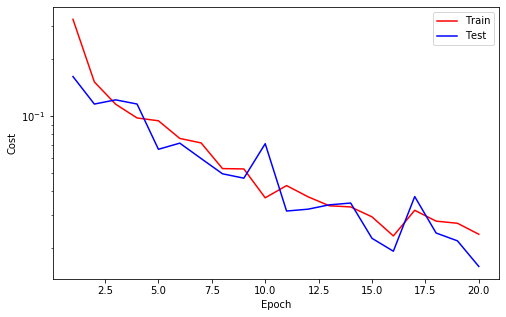

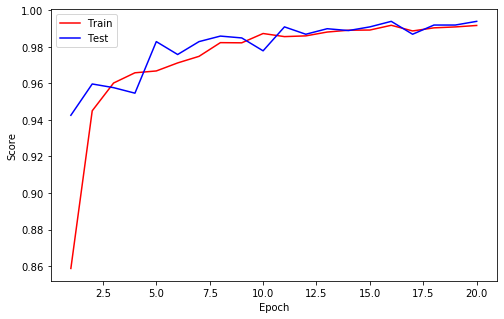

==> EarlyStop patience =  4 | Best test_score: 0.9940




Epoch    21
Train_cost  = 0.0275 | Test_cost  = 0.0311 | Train_score = 0.9900 | Test_score = 0.9909 |
==> EarlyStop patience =  5 | Best test_score: 0.9940
==> Execute Early Stopping at epoch: 21 | Best test_score: 0.9940
==> Best model is saved at model


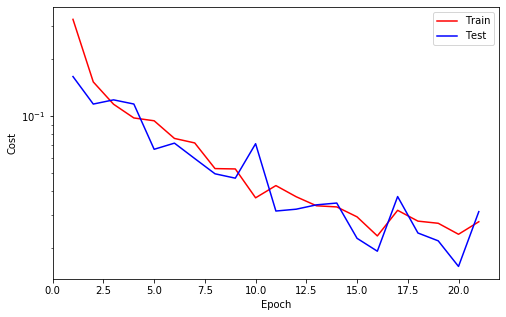

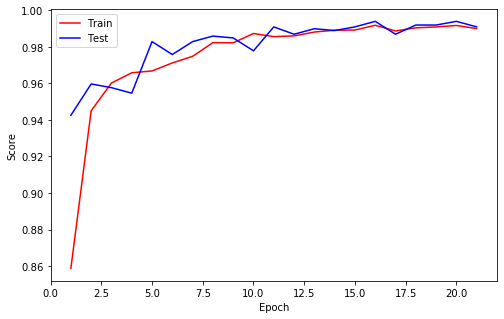

In [25]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

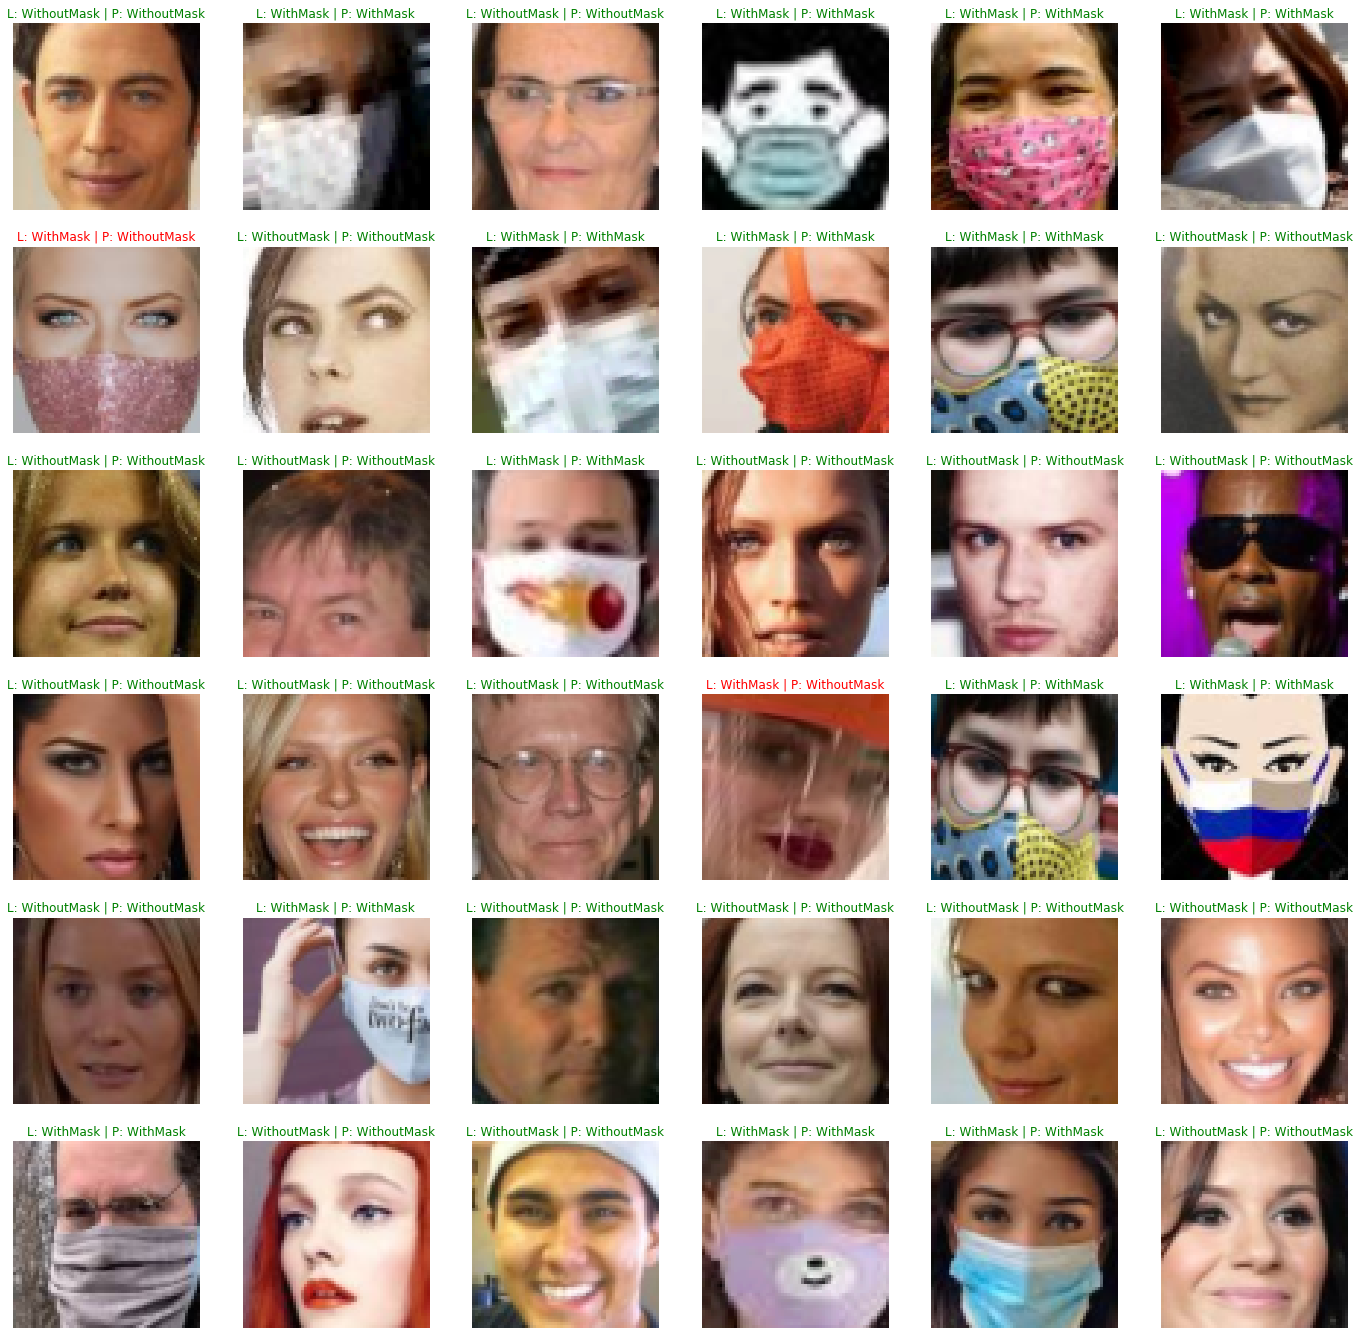

In [26]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)  
preds



fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');